In [1]:
import os
import h5py
import time
import torch
import pyreadr
import numpy as np
import pandas as pd
import datetime as dt
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from pandas.api.types import CategoricalDtype
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import weight_norm
from sklearn.manifold import TSNE
from livelossplot import PlotLosses
from pytorch_model_summary import summary
from tqdm.notebook import tqdm, trange
from sklearn.metrics import mean_squared_error

device = torch.device('cuda')

In [2]:
class MyDataset(torch.utils.data.Dataset):
    '''
    Class to load the dataset
    '''
    def __init__(self, w, y, idx):
        self.w = w
        self.y = y
        self.idx = idx
            
    def __len__(self):
        return len(self.idx)

    def __getitem__(self, idx):
            
        idx = self.idx[idx]
        
        ww = torch.tensor(self.w[idx], dtype=torch.float, device = device)
        yy = torch.tensor(self.y[idx], dtype=torch.float, device = device)
        
        return (ww, yy)

In [3]:
class MyNet(nn.Module):

    def __init__(self, w_layers, pred_layers):

        super().__init__()
              
        # CNN blocks
        w_layers_list = nn.ModuleList()
        for i, o, k, d in w_layers:
            w_layer = nn.Sequential(
                nn.Conv1d(i, o, k),
                nn.AvgPool1d(2),
                nn.LeakyReLU(),
                nn.BatchNorm1d(o),
                nn.Dropout(d)
            )
            w_layers_list.append(w_layer)
        w_layers_list.append(nn.AdaptiveAvgPool1d(1))
        self.w_layers = nn.Sequential(*w_layers_list)

        
        # FC blocks
        pred_layers_list = nn.ModuleList()
        for i, o, d in pred_layers:
            pred_layer = nn.Sequential(
                nn.Linear(i, o),
                nn.LeakyReLU(),
                nn.BatchNorm1d(o),
                nn.Dropout(d)
            )
            pred_layers_list.append(pred_layer)
        pred_layers_list.append(nn.Linear(o, 1))
        self.pred_layers = nn.Sequential(*pred_layers_list)
        
   
    def forward(self, Ws):
        
        feat = self.w_layers(Ws).view(Ws.shape[0], -1)
        pred = self.pred_layers(feat)
        return (torch.tanh(pred))


In [4]:
def load_data(wfiles, ydf):
    sim_ww = []
    sim_yy = []

    wfile = wfiles[10]
    for wfile in tqdm(wfiles):   
        ridx = np.arange(80,100)
        site = os.path.basename(wfile).replace('.csv', '')

        w = pd.read_csv(wfile, skiprows = 13)
        w.DAY = pd.to_datetime(w.DAY, format = '%Y%m%d').dt.date

        sydf = ydf.loc[site]
        sim_yy.append(sydf.Yield.values[ridx])

        wwf = []
        for crop_start_date in sydf.SIM_DATE.values[ridx]:
            cs_date = np.where(w.DAY == crop_start_date)[0][0]
            wrng = slice(cs_date-90, cs_date+210)
            ww = w.iloc[wrng,[1,2,3,4,6]].values / ws
            wwf.append(ww)

        sim_ww.append(np.concatenate(wwf))

    sim_ww = np.stack(sim_ww)
    sim_yy = np.stack(sim_yy)
    return(sim_ww, sim_yy)


In [5]:
# Values used to scale the weather data:
ws = np.array([[[5e4,50,50,5,100.0]]])

In [6]:
ydf = pd.read_hdf('../data/PSCE_TILE.h5', key = 'SIM').set_index('SIM')
ydf['Yield'] = (ydf.TWSO/2e4)

In [7]:
wdir = '/home/rodrigo7/Apsim_test/MASAGRO/DAYMET_TILE'
pxy = np.stack(np.meshgrid(np.arange(40), np.arange(40)), -1).reshape(-1, 2)
wfiles = [f'{wdir}/DAYMET_9584_{px:02d}_{py:02d}.csv' for px, py in pxy]

sim_ww, sim_yy = load_data(wfiles, ydf)

In [8]:
wd = np.zeros_like(sim_ww[:,:,:,[0]])
wd = wd + np.linspace(-0.9,2.1,300)[None,None,:,None]
W = np.concatenate([sim_ww, wd], -1)
W = np.moveaxis(W, -1, -2)

In [10]:
test_val_W = W.reshape(-1, *W.shape[2:])
test_val_y = sim_yy.reshape(-1, *sim_yy.shape[2:])
pred_idx = np.arange(len(test_val_y))

In [11]:
batch_size = 1000

test_dataset = MyDataset(test_val_W, test_val_y, pred_idx)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

data_inputs = iter(test_loader).next()
print(len(test_loader))


32


In [12]:
d = 0.1
w_layers =  [[6,12,3,d],[12,15,5,d],[15,20,7,d],[20,25,5,d],[25,100,3,d]]
pred_layers = [[100,50,d],[50,50,d], [50,25,d]]

In [13]:
train_methods = ['none', 'rnd', 'adv']

PCT = 1
REP = 1

dff = []
for REP in range(1,6):
    for train_method in train_methods:
        for PCT in [1,5]:
            model = MyNet(w_layers, pred_layers)
            model = model.to(device)
            model_file_name = f'../../APSIMDL/data/model_cnn_{train_method}_{PCT}_{REP}.pth'
            model.load_state_dict(torch.load(model_file_name, map_location=device))
            print(model_file_name)

            # Realiza a predição dos dados a partir do modelo treinado - Dados de validação
            model.eval()
            obs = []
            preds = []
            for i, (Ws, Ys) in enumerate(tqdm(test_loader)):
                obs.append(Ys.cpu().data.numpy())
                with torch.no_grad():
                    pred = model(Ws)
                preds.append(pred.cpu().data.numpy())
            obs = np.concatenate(obs)
            preds = np.concatenate(preds)

            x = preds.reshape(-1) * 2e4
            y = obs.reshape(-1) * 2e4

            df = pd.DataFrame(np.stack([x,y], 1), columns=['Yield_pred', 'Yield_obs'])
            df['train_method'] = train_method
            df['PCT'] = PCT
            df['REP'] = REP
            dff.append(df)
dff = pd.concat(dff)

../../APSIMDL/data/model_cnn_none_1_1.pth



../../APSIMDL/data/model_cnn_none_5_1.pth



../../APSIMDL/data/model_cnn_rnd_1_1.pth



../../APSIMDL/data/model_cnn_rnd_5_1.pth



../../APSIMDL/data/model_cnn_adv_1_1.pth



../../APSIMDL/data/model_cnn_adv_5_1.pth



../../APSIMDL/data/model_cnn_none_1_2.pth



../../APSIMDL/data/model_cnn_none_5_2.pth



../../APSIMDL/data/model_cnn_rnd_1_2.pth



../../APSIMDL/data/model_cnn_rnd_5_2.pth



../../APSIMDL/data/model_cnn_adv_1_2.pth



../../APSIMDL/data/model_cnn_adv_5_2.pth


In [24]:
def rmse( g ):
    rmse = np.sqrt( mean_squared_error( g['Yield_pred'], g['Yield_obs'] ) )
    return pd.Series( dict( rmse = rmse ) )

dfm = dff.groupby(['train_method', 'PCT']).apply( rmse ).reset_index()

In [28]:
print(dfm.to_latex(index = False))

\begin{tabular}{lrr}
\toprule
train\_method &  PCT &         rmse \\
\midrule
 adversarial &    1 &  1072.791260 \\
 adversarial &    5 &   983.102234 \\
        none &    1 &   922.940247 \\
        none &    5 &   708.556824 \\
      random &    1 &   985.607971 \\
      random &    5 &  1045.820557 \\
\bottomrule
\end{tabular}



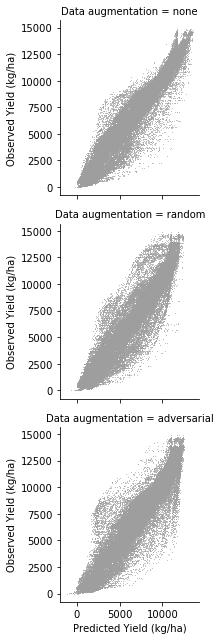

In [23]:
dff.train_method = dff.train_method.replace({'rnd':'random', 'adv':'adversarial'})
dff['Data augmentation'] = dff.train_method
dff['Observed Yield (kg/ha)'] = dff.Yield_obs
dff['Predicted Yield (kg/ha)'] = dff.Yield_pred


g = sns.FacetGrid(dff, row="Data augmentation")
g = g.map(sns.scatterplot, 'Predicted Yield (kg/ha)', 'Observed Yield (kg/ha)', s = 0.5,  linewidth=0, color = 'black')
plt.savefig('../figures/sca_test.png')